# CarND-Advanced-Lane-Lines
## Goals/Steps
> The goals / steps of this project are the following:
* include libs
* Compute the camera calibration matrix and distortion coefficients
* Apply a distortion correction
* Use color transforms, gradients
* Apply a perspective transform
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.
* Run pipeline in a video.

In [2]:
# the first step importing the libs 
import cv2
import glob
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import numpy as np
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

In [3]:
# the second step is to compute camera calibration
def calibrate_camera(images, nx=9, ny=6):
    objp = np.zeros((nx * ny, 3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Step through the list and search for chessboard corners
    img = None
    for fname in images:    
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    return ret, mtx, dist, rvecs, tvecs
        
# Make a list of calibration images
imgs = glob.glob('camera_cal/calibration*.jpg')
ret, mtx, dist, rvecs, tvecs = calibrate_camera(imgs)
imgs

['camera_cal/calibration16.jpg',
 'camera_cal/calibration13.jpg',
 'camera_cal/calibration17.jpg',
 'camera_cal/calibration12.jpg',
 'camera_cal/calibration20.jpg',
 'camera_cal/calibration15.jpg',
 'camera_cal/calibration4.jpg',
 'camera_cal/calibration11.jpg',
 'camera_cal/calibration3.jpg',
 'camera_cal/calibration9.jpg',
 'camera_cal/calibration8.jpg',
 'camera_cal/calibration1.jpg',
 'camera_cal/calibration5.jpg',
 'camera_cal/calibration14.jpg',
 'camera_cal/calibration19.jpg',
 'camera_cal/calibration2.jpg',
 'camera_cal/calibration10.jpg',
 'camera_cal/calibration18.jpg',
 'camera_cal/calibration6.jpg',
 'camera_cal/calibration7.jpg']

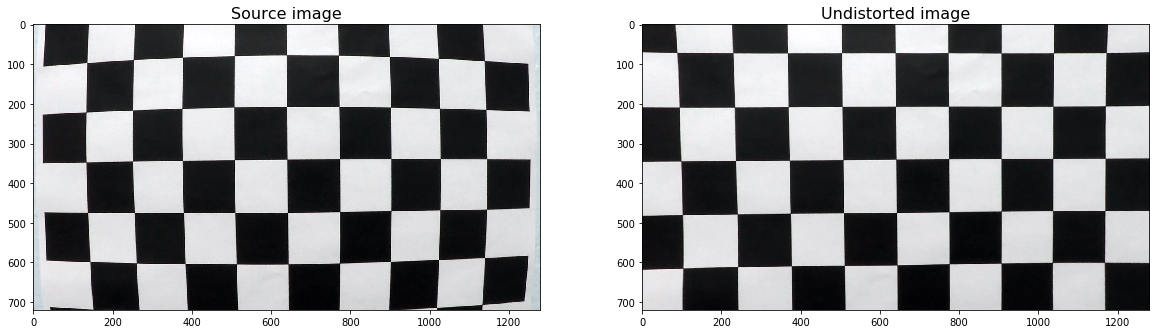

In [4]:
# applying the function
ii = imgs[0]
img = cv2.imread('camera_cal/calibration1.jpg')
undistorted_img = cv2.undistort(img, mtx, dist, None, mtx)

def plt_images(img_1, title_1, img_2, title_2, cmap='gray'):
    # Visualize undirstorsion
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    ax1.set_title(title_1, fontsize=16)
    ax1.imshow(img_1)
    ax2.set_title(title_2, fontsize=16)
    ax2.imshow(img_2, cmap='gray')
plt_images(img, 'Source image', undistorted_img, 'Undistorted image')
plt.imsave("output_images/" + ii[11:-4] + "undistorted.jpg", undistorted_img)

In [5]:
# the third step is to Use color transforms, gradients, etc., to create a thresholded binary image
img = cv2.imread('./test_images/test1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.undistort(img, mtx, dist, None, mtx)
# Define a function that applies Sobel x or y, 
# then takes an absolute value and applies a threshold.
# Note: calling your function with orient='x', thresh_min=5, thresh_max=100
# should produce output like the example image shown above this quiz.
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, sobel_kernel))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    # Return the result
    return binary_output

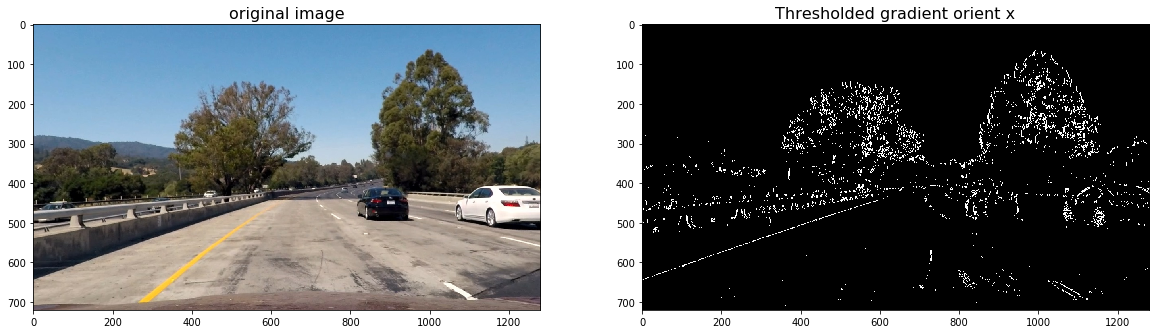

In [6]:
# applying the function
x_grad = abs_sobel_thresh(img, orient='x', sobel_kernel=15, thresh=(30, 100))
plt.imsave("output_images/" + 'test1' + "hresholded_gradient_orient_x.jpg", x_grad)
plt_images(img, 'original image', x_grad, 'Thresholded gradient orient x')

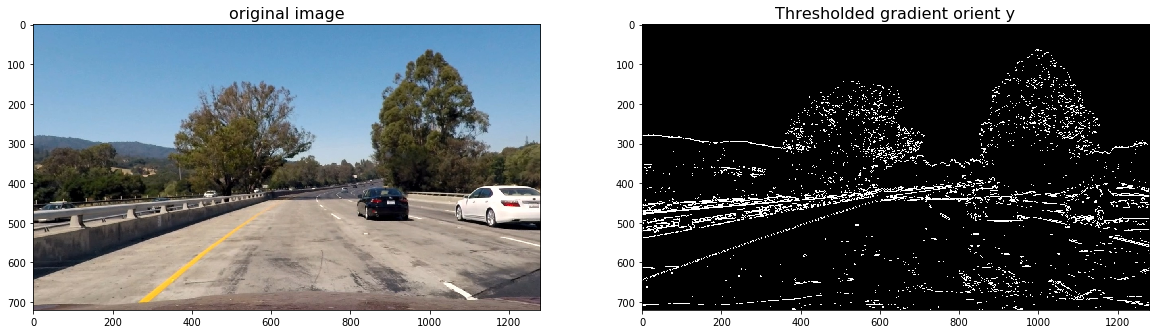

In [7]:
# applying the function
y_grad = abs_sobel_thresh(img, orient='y', sobel_kernel=15, thresh=(30, 100))
plt.imsave("output_images/" + 'test1' + "hresholded_gradient_orient_y.jpg", y_grad)
plt_images(img, 'original image', y_grad, 'Thresholded gradient orient y')

In [8]:
# computing the magnitude of the gradient and applies a threshold
def magude_thres(img, sobel_kernel=3, thresh=(0, 255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= thresh[0]) & (gradmag <= thresh[1])] = 1
    return binary_output

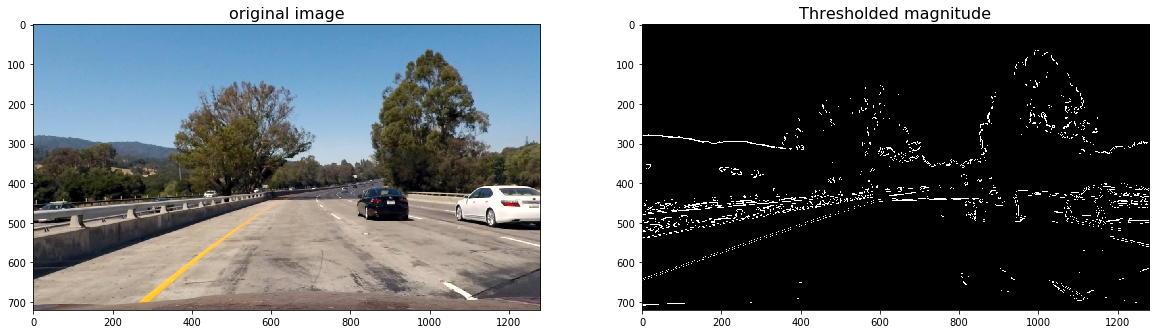

In [9]:
# applying the function 
mag_binary = magude_thres(img, sobel_kernel=15, thresh=(70, 100))
plt.imsave("output_images/" + 'test1' + "hresholded_magnitude.jpg", mag_binary)
plt_images(img, 'original image', mag_binary, 'Thresholded magnitude')

In [10]:
# computing the gradient direction 
def dir_thresh(img, sobel_kernel=9, thresh=(0, np.pi/2)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    return binary_output

In [11]:
# applying the function
dir_binary = dir_thresh(img, sobel_kernel=15, thresh=(0.7, 1.3))
plt.imsave("output_images/" + 'test1' + "dir_thresh.jpg", dir_binary)
plt_images(img, 'original image', dir_binary, 'Thresholded gradient direction')

In [12]:
# computing color threshold
def col_thresh(img, thresh=(170, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2] 
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel >= thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output
# applying the function
col_binary = col_thresh(img, thresh=(170, 255))
plt.imsave("output_images/" + 'test1' + "col_thresh.jpg", col_binary)
plt_images(img, 'Original image', col_binary, 'Color thresholded')

In [13]:
# to identify the lane lines
def combine_threshs(grad_x, grad_y, mag_binary, dir_binary, col_binary, ksize=15):
    combined = np.zeros_like(dir_binary)
    combined[((grad_x == 1) & (grad_y == 1)) | ((mag_binary == 1) & (dir_binary == 1)) | (col_binary == 1)] = 1
    return combined
# applying the function 
# Run the function
combined = combine_threshs(x_grad, y_grad, mag_binary, dir_binary, col_binary, ksize=15)
plt.imsave("output_images/" + 'test1' + "combine_threshs.jpg", combined)
plt_images(img, 'original image', combined, 'Thresholds combined')

In [14]:
# forth step Applying a perspective transform
def warped(img, src_coordinates=None, dst_coordinates=None):
    img_size = (img.shape[1], img.shape[0])
    if src_coordinates is None:
        src_coordinates = np.float32(
            [[280,  700],  # Bottom left
             [595,  460],  # Top left
             [725,  460],  # Top right
             [1125, 700]]) # Bottom right
    if dst_coordinates is None:
        dst_coordinates = np.float32(
            [[250,  720],  # Bottom left
             [250,    0],  # Top left
             [1065,   0],  # Top right
             [1065, 720]]) # Bottom right   
    # Compute the perspective transfor :  M
    M = cv2.getPerspectiveTransform(src_coordinates, dst_coordinates)
    # Compute the inverse perspective transfor also by swapping the input parameters
    Minv = cv2.getPerspectiveTransform(dst_coordinates, src_coordinates)
    # Create warped image - uses linear interpolation
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped, M, Minv
# applay the function
src_coordinates = np.float32(
    [[280,  700],  # Bottom left
     [595,  460],  # Top left
     [725,  460],  # Top right
     [1125, 700]]) # Bottom right
dst_coordinates = np.float32(
    [[250,  720],  # Bottom left
     [250,    0],  # Top left
     [1065,   0],  # Top right
     [1065, 720]]) # Bottom right   
warped_img, _ , Minv  = warped(img, src_coordinates, dst_coordinates)

# Visualize undirstorsion
# Notice 'img' was undistorted at the beginning
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Undistorted image with source points drawn', fontsize=16)
ax1.plot(Polygon(src_coordinates).get_xy()[:, 0], Polygon(src_coordinates).get_xy()[:, 1], color='red')
ax1.imshow(img)
ax2.set_title('Warped image with destination points drawn', fontsize=16)
ax2.plot(Polygon(dst_coordinates).get_xy()[:, 0], Polygon(dst_coordinates).get_xy()[:, 1], color='red')
ax2.imshow(warped_img)
plt.imsave("output_images/" + 'test1' + "Warped_image.jpg", warped_img)

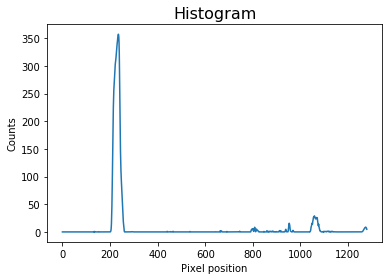

In [18]:
# fifth step is to Detect lane pixels
def get_histogram(img):
    return np.sum(img[img.shape[0]//2:, :], axis=0)
# Run de function over the combined warped image
combined_warped = warped(combined)[0]
histogram = get_histogram(combined_warped)
# Plot the results
plt.title('Histogram', fontsize=16)
plt.xlabel('Pixel position')
plt.ylabel('Counts')
plt.plot(histogram)
#plt.imsave("output_images/" + 'test1' + "Histogram.jpg", histogram)

In [20]:
def detect_lines(img, return_img=False):
    histogram = get_histogram(img)
    if return_img:
        out_img = np.dstack((img, img, img))*255
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    nwindows = 9
    window_height = np.int(img.shape[0]//nwindows)
    nonzero = img.nonzero()
    nonzerox = np.array(nonzero[1])   
    nonzeroy = np.array(nonzero[0])
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window + 1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        if return_img:
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high), (0,255,0), 3) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high), (0,255,0), 3) 

        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                          (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                           (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    ploty = np.linspace(0, img.shape[0] - 1, img.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    if return_img:
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

        # Draw left and right lines
        for index in range(img.shape[0]):
            cv2.circle(out_img, (int(left_fitx[index]), int(ploty[index])), 3, (255,255,0))
            cv2.circle(out_img, (int(right_fitx[index]), int(ploty[index])), 3, (255,255,0))
            
        return (left_fit, right_fit), (left_fitx, ploty), (right_fitx, ploty), out_img.astype(int)

    return (left_fit, right_fit), (left_fitx, ploty), (right_fitx, ploty)


In [21]:
# applying the function
lines_fit, left_points, right_points, out_img = detect_lines(combined_warped, return_img=True)
plt_images(warped_img, 'Warped image', out_img, 'Lane lines detected')
plt.imsave("output_images/" + 'test1' + "lines_detected.png", out_img)

In [22]:
def detect_similar_lines(img, line_fits=None, return_img=False):
    if line_fits is None:
        return detect_lines(img, return_img)
    left_fit = line_fits[0]
    right_fit = line_fits[1]
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # If any of the lines could not be found, 
    # perform a more exhaustive search
    if (leftx.size == 0 or rightx.size == 0):
        return detect_lines(img, return_img)
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img.shape[0] - 1, img.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    if return_img:
        # Create an image to draw on and an image to show the selection window
        out_img = np.dstack((img, img, img))*255
        window_img = np.zeros_like(out_img)
        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx - margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx + margin, ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx - margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx + margin, ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))
        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        out_img = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
        # Color in left and right line pixels
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
     
        for index in range(img.shape[0]):
            cv2.circle(out_img, (int(left_fitx[index]), int(ploty[index])), 3, (255,255,0))
            cv2.circle(out_img, (int(right_fitx[index]), int(ploty[index])), 3, (255,255,0))
    
        return (left_fit, right_fit), (left_fitx, ploty), (right_fitx, ploty), out_img.astype(int)
    
    return (left_fit, right_fit), (left_fitx, ploty), (right_fitx, ploty)

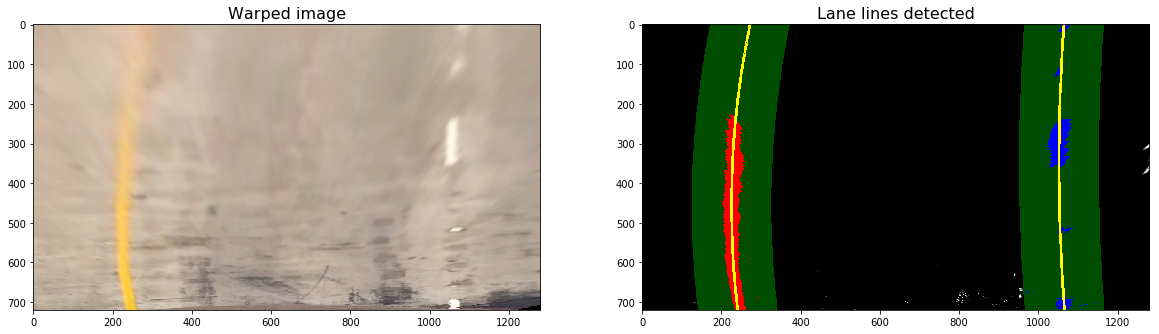

In [23]:
# applying the function
lines_fit, left_points, right_points, out_img = detect_similar_lines(combined_warped, lines_fit, return_img=True)
plt_images(warped_img, 'Warped image', out_img, 'Lane lines detected')
plt.imsave("output_images/" + 'test1' + "similar_lines_detected.png", out_img)

In [24]:
# sixth step computing curvature radius and vehicle position
def curvature_radius (leftx, rightx, img_shape, xm_per_pix=3.7/800, ym_per_pix = 25/720):
    ploty = np.linspace(0, img_shape[0] - 1, img_shape[0])
    
    leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
    rightx = rightx[::-1]  # Reverse to match top-to-bottom in y
    
    # Fit a second order polynomial to pixel positions in each fake lane line
    left_fit = np.polyfit(ploty, leftx, 2)
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fit = np.polyfit(ploty, rightx, 2)
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 25/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/800 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    y_eval = np.max(ploty)
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    # Now our radius of curvature is in meters
    return (left_curverad, right_curverad)

# applying the function 
curvature_rads = curvature_radius(leftx=left_points[0], rightx=right_points[0], img_shape = img.shape)
print('Left line curvature is : ', curvature_rads[0], 'm')
print('Right line curvature is : ', curvature_rads[1], 'm')

Left line curvature is :  577.4153793211691 m
Right line curvature is :  1262.0099992208216 m


In [25]:
def car_offset(leftx, rightx, img_shape, xm_per_pix=3.7/800):
    mid_imgx = img_shape[1]//2
    car_pos = (leftx[-1] + rightx[-1])/2
    offsetx = (mid_imgx - car_pos) * xm_per_pix
    return offsetx

# applying the function  
offsetx = car_offset(leftx=left_points[0], rightx=right_points[0], img_shape=img.shape)
print ('Car offset from center is :', offsetx, 'm.')

Car offset from center is : -0.06043692474343512 m.


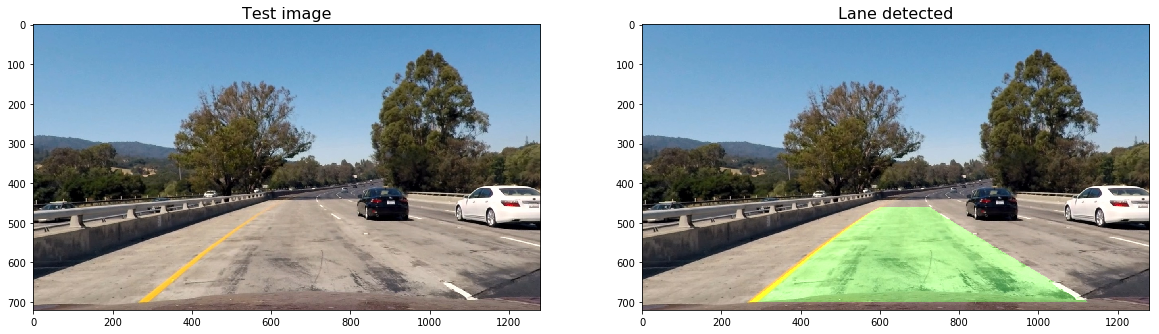

In [26]:
# seventh step is to  Warp the detected lane boundaries back onto the original image
def draw_lane(img, warped_img, left_points, right_points, Minv):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    # Recast the x and y points into usable format for cv2.fillPoly()
    left_fitx = left_points[0]
    right_fitx = right_points[0]
    ploty = left_points[1]
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    return cv2.addWeighted(img, 1, newwarp, 0.3, 0)

# Applying the function
img_lane = draw_lane(img, combined_warped, left_points, right_points, Minv)
plt_images(img, 'Test image', img_lane, 'Lane detected')
plt.imsave("output_images/" + 'test1' + "_draw_lane.png", img_lane)

In [28]:
def add_metrics(img, leftx, rightx, xm_per_pix=3.7/800, ym_per_pix = 25/720):    
    # Calculate radius of curvature
    curvature_rads = curvature_radius(leftx=leftx, rightx=rightx, img_shape=img.shape,
                                      xm_per_pix=xm_per_pix, ym_per_pix=ym_per_pix)
    # Calculate car offset
    offsetx = car_offset(leftx=leftx, rightx=rightx, img_shape=img.shape)
    # Display lane curvature
    out_img = img.copy()
    cv2.putText(out_img, 'Left lane line curvature: {:.2f} m'.format(curvature_rads[0]), 
                (60, 60), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), 5)
    cv2.putText(out_img, 'Right lane line curvature: {:.2f} m'.format(curvature_rads[1]), 
                (60, 110), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), 5)
    # Display car offset
    cv2.putText(out_img, 'Horizontal car offset: {:.2f} m'.format(offsetx), 
                (60, 160), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), 5)
    return out_img
# applying the function
out_img = add_metrics(img_lane, leftx=left_points[0], rightx=right_points[0])
plt_images(img, 'Test image', out_img, 'Lane detected with metrics')
plt.imsave("output_images/" + 'test1' + "_draw_lane_matrices.png", out_img)

In [33]:
# the last step 
class ProcessImage:
    def __init__(self, images):
        # Make a list of calibration images
        images = glob.glob(images)
        # Calibrate camera
        self.ret, self.mtx, self.dist, self.rvecs, self.tvecs = calibrate_camera(images)
        self.lines_fit = None
    def __call__(self, img):
        # Undistord image
        img = cv2.undistort(img, mtx, dist, None, mtx)

        # Calculate directional gradient
        grad_binary = abs_sobel_thresh(img, orient='x', sobel_kernel=15, thresh=(30, 100))

        # Calculate gradient magnitude 
        mag_binary = magude_thres(img, sobel_kernel=15, thresh=(50, 100))

        # Calculate gradient direction
        dir_binary = dir_thresh(img, sobel_kernel=15, thresh=(0.7, 1.3))

        # Calculate color threshold
        col_binary = col_thresh(img, thresh=(170, 255))

        # Combine all the thresholds to identify the lane lines
        combined = combine_threshs(x_grad, y_grad, mag_binary, dir_binary, col_binary, ksize=15)

        # Apply a perspective transform to rectify binary image ("birds-eye view")
        src_coordinates = np.float32(
            [[280,  700],  # Bottom left
             [595,  460],  # Top left
             [725,  460],  # Top right
             [1125, 700]]) # Bottom right

        dst_coordinates = np.float32(
            [[250,  720],  # Bottom left
             [250,    0],  # Top left
             [1065,   0],  # Top right
             [1065, 720]]) # Bottom right   

        combined_warped, _, Minv = warped(combined, src_coordinates, dst_coordinates)
                
        self.lines_fit, left_points, right_points, out_img = detect_similar_lines(combined_warped, self.lines_fit, return_img=True)

        # Warp the detected lane boundaries back onto the original image.
        img_lane = draw_lane(img, combined_warped, left_points, right_points, Minv)
            
        # Add metrics to the output img
        out_img = add_metrics(img_lane, leftx=left_points[0], rightx=right_points[0])
            
        return out_img

In [34]:
input_video = 'project_video.mp4'
output_video = 'ouput_vidoes/project_video_output.mp4'

clip1 = VideoFileClip(input_video)
process_image = ProcessImage('./camera_cal/calibration*.jpg')

white_clip = clip1.fl_image(process_image)

%time white_clip.write_videofile(output_video, audio=False)

[MoviePy] >>>> Building video ouput_vidoes/project_video_output.mp4
[MoviePy] Writing video ouput_vidoes/project_video_output.mp4


100%|█████████▉| 1260/1261 [09:46<00:00,  2.22it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ouput_vidoes/project_video_output.mp4 

CPU times: user 19min 27s, sys: 1min 39s, total: 21min 6s
Wall time: 9min 48s


In [35]:
HTML("""
<video width="650" height="400" controls>
  <source src="{0}">
</video>
""".format(output_video))